Note: This Kernel is part of our ongoing `Learn Deep learning by competing in Live Kaggle competition` [course](https://www.youtube.com/watch?v=rnJG12vIuFc&t=2s).

# SIIM-ISIC Melanoma Classification

In this competition we need to identify whether a skin lesion has Melanoma or Not. It is a very difficult problem primarily for 2 reasons -

1. For an untrained human eye it is very difficult to distinguish whether a given image has Melanoma or not.
2. The dataset is highly imbalanced.


This is a simple starter notebook for Kaggle's Melanoma Comp, showing how to use 

- PyTorch
- Albumentations
- Chris Deotte [triple stratified data](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164092)
- Chris Deotte resized [data](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164092) of 256,256
- Different EfficientNet models
- Apply N number of TTA for predicitons.
- Use a 80/20 split for comparing experiments across competitions. 

In [1]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=fde14ec898eed3ca1f130c45638638acb1a09857a912fab1e38ed186b02b5d35
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch


In [2]:
from pathlib import Path
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from torchvision import transforms as T
import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.model_selection import GroupKFold
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar
from sklearn.metrics import accuracy_score, roc_auc_score
from efficientnet_pytorch import EfficientNet
from torchvision import models
import pdb
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import matplotlib.pyplot as plt

import pickle 

In [3]:
def list_files(path:Path):
    return [o for o in path.iterdir()]

# Data Exploration

In [4]:
path = Path('../input/jpeg-melanoma-256x256/')
df_path = Path('../input/melanoma-256x256/')
im_sz = 256
bs = 16

In [5]:
train_fnames = list_files(path/'train')
df = pd.read_csv(df_path/'train.csv')
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4


The dataset contains around 35K images out of which only 584 images are malignant. That makes only 1.8% of the total dataset.

In [6]:
df.target.value_counts(),df.shape

(0    32542
 1      584
 Name: target, dtype: int64,
 (33126, 12))

Samples with Melanoma


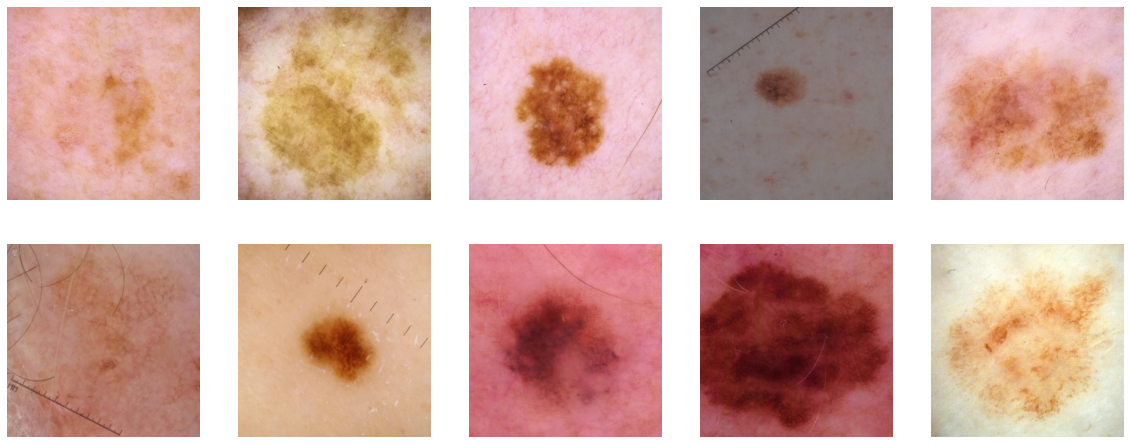

Samples without Melanoma


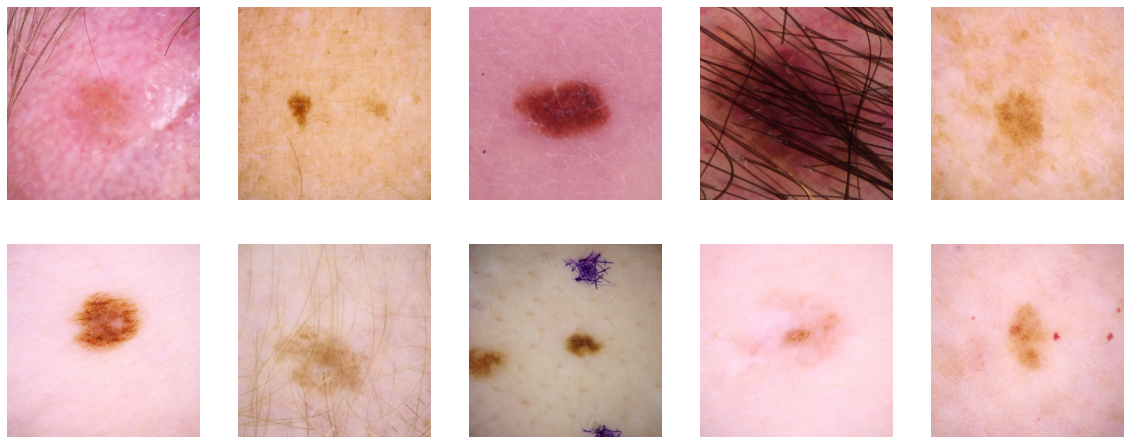

In [7]:
print("Samples with Melanoma")
imgs = df[df.target==1]['image_name'].values
_, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'train/{f_name}.jpg')
    ax.imshow(img)
    ax.axis('off')
plt.show()

print("Samples without Melanoma")
imgs = df[df.target==0]['image_name'].values
_, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'train/{f_name}.jpg')
    ax.imshow(img)
    ax.axis('off')    
plt.show()


# Data Augmentation

We use albumentations to perform augmentations. Since the dataset is small and we are not using any external dataset in this Kernel, an increased augmentation can be helpful. You can play with the augmentation argument to either increase or decrease the amount of data augmentation applied.

In [8]:
def get_augmentations(p=0.5):
    imagenet_stats = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}
    train_tfms = A.Compose([
        A.Cutout(p=p),
        A.RandomRotate90(p=p),
        A.Flip(p=p),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2,
                                       contrast_limit=0.2,
                                       ),
            A.HueSaturationValue(
                hue_shift_limit=20,
                sat_shift_limit=50,
                val_shift_limit=50)
        ], p=p),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=p),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=p),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=p),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=0.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=p), 
        ToTensor(normalize=imagenet_stats)
        ])
    
    test_tfms = A.Compose([
        ToTensor(normalize=imagenet_stats)
        ])
    return train_tfms, test_tfms

# Train/Validation split
- We use a simple 80/20 split based on the triple stratified K-Fold split. 
- We remove all the duplicate images.
- TF record - id with values 12,13,14 are put into validation split and the rest into train split.

In [9]:
def get_train_val_split(df):
    #Remove Duplicates
    df = df[df.tfrecord != -1].reset_index(drop=True)
    #We are splitting data based on triple stratified kernel provided here https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/165526
    train_tf_records = list(range(len(df.tfrecord.unique())))[:12]
    split_cond = df.tfrecord.apply(lambda x: x in train_tf_records)
    train_df = df[split_cond].reset_index()
    valid_df = df[~split_cond].reset_index()
    return train_df,valid_df

# Dataset

In [10]:
class MelanomaDataset(Dataset):
    def __init__(self,df,im_path,transforms=None,is_test=False):
        self.df = df
        self.im_path = im_path
        self.transforms = transforms
        self.is_test = is_test
        
    def __getitem__(self,idx):
        img_path = f"{self.im_path}/{self.df.iloc[idx]['image_name']}.jpg"
        img = Image.open(img_path)
        if self.transforms:
            img = self.transforms(**{"image": np.array(img)})["image"]
            
        if self.is_test:
            return img
        target = self.df.iloc[idx]['target']
        return img,torch.tensor([target],dtype=torch.float32)
    
    def __len__(self):
        return self.df.shape[0]
        

# Model 

Efficientnets have proved themselves in the last year as a key to winning competitions. You can try different Efficientnet model by passing the right model name. Changing the number in the model name `efficientnet-b0` gives you different models. The larger the number the more complex/bigger and better the model is. 

In [11]:
class MelanomaEfficientNet(nn.Module):
    def __init__(self,model_name='efficientnet-b0',pool_type=F.adaptive_avg_pool2d):
        super().__init__()
        self.pool_type = pool_type
        self.backbone = EfficientNet.from_pretrained(model_name)
        in_features = getattr(self.backbone,'_fc').in_features
        self.classifier = nn.Linear(in_features,1)

    def forward(self,x):
        features = self.pool_type(self.backbone.extract_features(x),1)
        features = features.view(x.size(0),-1)
        return self.classifier(features)

# Helper functions 
- Split data to train and validation split
- Get model, choose different optimizer, freeze backbone, different learning rates/weight decay.
- The training method by default uses cosine annealing for scheduling learning rate, you can experiment with.

In [12]:
def get_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def get_model(model_name='efficientnet-b0',lr=1e-5,wd=0.01,freeze_backbone=False,opt_fn=torch.optim.AdamW,device=None):
    device = device if device else get_device()
    model = MelanomaEfficientNet(model_name=model_name)
    if freeze_backbone:
        for parameter in model.backbone.parameters():
            parameter.requires_grad = False
    opt = opt_fn(model.parameters(),lr=lr,weight_decay=wd)
    model = model.to(device)
    return model, opt

def training_step(xb,yb,model,loss_fn,opt,device,scheduler):
    xb,yb = xb.to(device), yb.to(device)
    out = model(xb)
    opt.zero_grad()
    loss = loss_fn(out,yb)
    loss.backward()
    opt.step()
    scheduler.step()
    return loss.item()
    
def validation_step(xb,yb,model,loss_fn,device):
    xb,yb = xb.to(device), yb.to(device)
    out = model(xb)
    loss = loss_fn(out,yb)
    out = torch.sigmoid(out)
    return loss.item(),out

def get_data(train_df,valid_df,train_tfms,test_tfms,bs):
    train_ds = MelanomaDataset(df=train_df,im_path=path/'train',transforms=train_tfms)
    valid_ds = MelanomaDataset(df=valid_df,im_path=path/'train',transforms=test_tfms)
    train_dl = DataLoader(dataset=train_ds,batch_size=bs,shuffle=True,num_workers=4)
    valid_dl = DataLoader(dataset=valid_ds,batch_size=bs*2,shuffle=False,num_workers=4)
    return train_dl,valid_dl

In [13]:
def fit(epochs,model,train_dl,valid_dl,opt,device=None,loss_fn=F.binary_cross_entropy_with_logits):
    
    device = device if device else get_device()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dl)*epochs)
    val_rocs = [] 
    
    #Creating progress bar
    mb = master_bar(range(epochs))
    mb.write(['epoch','train_loss','valid_loss','val_roc'],table=True)

    for epoch in mb:    
        trn_loss,val_loss = 0.0,0.0
        val_preds = np.zeros((len(valid_dl.dataset),1))
        val_targs = np.zeros((len(valid_dl.dataset),1))
        
        #Training
        model.train()
        
        #For every batch 
        for xb,yb in progress_bar(train_dl,parent=mb):
            trn_loss += training_step(xb,yb,model,loss_fn,opt,device,scheduler) 
        trn_loss /= mb.child.total

        #Validation
        model.eval()
        with torch.no_grad():
            for i,(xb,yb) in enumerate(progress_bar(valid_dl,parent=mb)):
                loss,out = validation_step(xb,yb,model,loss_fn,device)
                val_loss += loss
                bs = xb.shape[0]
                val_preds[i*bs:i*bs+bs] = out.cpu().numpy()
                val_targs[i*bs:i*bs+bs] = yb.cpu().numpy()

        val_loss /= mb.child.total
        val_roc = roc_auc_score(val_targs.reshape(-1),val_preds.reshape(-1))
        val_rocs.append(val_roc)

        mb.write([epoch,f'{trn_loss:.6f}',f'{val_loss:.6f}',f'{val_roc:.6f}'],table=True)
    return model,val_rocs

In [14]:
df = pd.read_csv(df_path/'train.csv')
train_df,valid_df = get_train_val_split(df)
train_tfms,test_tfms = get_augmentations(p=0.5)
train_dl,valid_dl = get_data(train_df,valid_df,train_tfms,test_tfms,bs)
model, opt = get_model(model_name='efficientnet-b5',lr=1e-4,wd=1e-4)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


I trained the model on my local machine. You can uncomment below code to start training here.

In [15]:
# model,val_rocs = fit(10,model,train_dl,valid_dl,opt)
# torch.save(model.state_dict(),f'effb5.pth')

# Generate test predictions

- By default we use the same data augmentation techniques that we applied during training. 
- Tweak the TTA parameter in `get_preds()` to increase the number of times TTA is applied.
- If you do not want TTA, change `transforms` to `test_transforms`.


In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [17]:
test_tfms = A.Compose([
    A.RandomRotate90(p=p),
        A.Flip(p=p),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2,
                                       contrast_limit=0.2,
                                       ),
            A.HueSaturationValue(
                hue_shift_limit=20,
                sat_shift_limit=50,
                val_shift_limit=50)
        ], p=p),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=p),
    ToTensor(normalize=imagenet_stats)
    ])

NameError: name 'p' is not defined

In [18]:
test_df = pd.read_csv(path/'test.csv')

model, opt = get_model(model_name='efficientnet-b5',lr=1e-4,wd=1e-4)
model.load_state_dict(torch.load(f'../input/melanomaefficientnetb5/effb5.pth',map_location=device))

#Testing with lighter augmentation
test_ds = MelanomaDataset(df=test_df,im_path=path/'test',transforms=test_tfms,is_test=True)
test_dl = DataLoader(dataset=test_ds,batch_size=bs*2,shuffle=False,num_workers=4)

Loaded pretrained weights for efficientnet-b5


In [19]:
def get_preds(model,device=None,tta=3):
    if device is None:
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    preds = np.zeros(len(test_ds))
    for tta_id in range(tta):
        test_preds = []
        with torch.no_grad():
            for xb in test_dl:
                xb = xb.to(device)
                out = model(xb)
                out = torch.sigmoid(out)
                test_preds.extend(out.cpu().numpy())
            preds += np.array(test_preds).reshape(-1)
        print(f'TTA {tta_id}')
    preds /= tta
    return preds

#Changing tta to 25 from 10
preds = get_preds(model,tta=25)  

TTA 0
TTA 1
TTA 2
TTA 3
TTA 4
TTA 5
TTA 6
TTA 7
TTA 8
TTA 9
TTA 10
TTA 11
TTA 12
TTA 13
TTA 14
TTA 15
TTA 16
TTA 17
TTA 18
TTA 19
TTA 20
TTA 21
TTA 22
TTA 23
TTA 24


In [20]:
subm = pd.read_csv(path/'sample_submission.csv')
subm.target = preds
subm.to_csv('submission.csv',index=False)

# Things to try next

Some of the tricks that can help in improving score are you can.

- Try training on higher image sizes.
- Try larger/different models.
- Try different loss functions like Focal Loss.
- Try Label smoothing.
- Try Focal Loss + Label smoothing
- Different Pooling layers

Thank you for reading. Hope you find this kernel useful. 
I will add more ideas in upcoming versions. 
Please consider upvoting and sharing the kernel.